## Import libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy
import numpy as np
from sklearn.preprocessing import StandardScaler

from pyrolite.comp import pyrocomp
import optuna
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.signal import savgol_filter
import scipy.stats as st
import seaborn as sns
import lightgbm
from lightgbm import LGBMRegressor
import random
import time
import sklearn
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

from sys import stdout
from sklearn.decomposition import PCA
from sklearn.utils import resample
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler
import xgboost 
from sklearn.ensemble import RandomForestRegressor

from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# Affichage des versions
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'numpy version: {np.__version__}')
print(f'optuna version: {optuna.__version__}')
print(f'scipy version: {scipy.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'lightgbm version: {lightgbm.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')
print(f'xgboost version: {xgboost.__version__}')


pandas version: 2.1.4
matplotlib version: 3.8.0
numpy version: 1.26.4
optuna version: 3.6.1
scipy version: 1.11.4
seaborn version: 0.12.2
lightgbm version: 4.3.0
scikit-learn version: 1.2.2
xgboost version: 2.0.3


## Codes for hyperparameters optimization

In [21]:
# Define a custom scoring function using r2_score between actual and predicted data
def custom_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Objective function for RandomForestRegressor
def objective_rfr(trial):
    param = {
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 2, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 1.0),
    }

    regressor_obj = RandomForestRegressor(**param)
    
    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())

    # Return the mean of the cross-validation scores
    return scores.mean()

# Objective function for XGBRegressor
def objective_xgbr(trial):
    ## Define search space for hyperparameters
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),  
        'gamma': trial.suggest_float("gamma", 0, 2),  
        'learning_rate': trial.suggest_float("eta", 0.01, 0.03),  
        'subsample': trial.suggest_float("subsample", 0.6, 0.9),  
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),  
        'lambda': trial.suggest_float("lambda", 1e-1, 1000),  
        'alpha': trial.suggest_float("alpha", 1e-1, 1000),  
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 0.9)  
    }

    regressor_obj = xgboost.XGBRegressor(**param)

    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())

    # Return the mean of the cross-validation scores
    return scores.mean()

# Objective function for LGBMRegressor
def objective_lgbr(trial):
    param = {
        'metric': 'mae',
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 2, 75),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-1, 1000),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.5, 0.6]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'num_leaves': trial.suggest_int('num_leaves', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }

    regressor_obj = LGBMRegressor(**param)

    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())

    # Return the mean of the cross-validation scores
    return scores.mean()

# Objective function for Support Vector Regressor
def objective_svr(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    param = {
        'kernel': kernel,
        'C': trial.suggest_loguniform('C', 0.1, 1),  
        'epsilon': trial.suggest_loguniform('epsilon', 1e-2, 1) 
    }

    if kernel == "rbf":
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 0.1) 

    regressor_obj = SVR(**param)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring='r2')

    trial.set_user_attr(key='train_r2', value=scores.mean())

    return scores.mean()

# Objective function for PLSRegression
def objective_plsr(trial):
    param = {
        'n_components': trial.suggest_int('n_components', 2, 8),
        'tol': trial.suggest_float('tol', 1e-8, 1e-2),
        'scale': trial.suggest_categorical('scale', [True, False])
    }

    regressor_obj = PLSRegression(**param)

    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())
    # Return the mean of the cross-validation scores
    return scores.mean()


## Import datasets

In [5]:
#data = pd.read_csv (r'path_to_file\file.csv')
data = pd.read_csv (r'I:\Phd\Articles\Resistivity_Inversion\Data\Logs_Basin.csv')

geochem = data.loc[:, 'Ag':'Filler'] ## Supposing geochem columns go from "Ag" to "Filler"
spectral = data.loc[:, '500':'2400'] ## Select wavelengths associated to IR and storing them in another dataframe.

## Load IR spectra already processed using continuum removal
removed_spectra = np.load(r'I:\Phd\Articles\Resistivity_Inversion\Data\Clean_Data\CR_Spectra.npy')
removed_spectra = pd.DataFrame (removed_spectra, columns = wvl)
data_cr = pd.concat ([data.loc[:, 'HoleName':'Filler'], removed_spectra], axis = 1, sort = False)

## Blind well train-test split

In [6]:
## Separation of an external dataset. In the presented paper, this was made by separating all samples belonging to the 'GET' (Getty Russell) project. 
data_ml = data.loc[data['Project'] != 'GET']
data_get = data.loc[data['Project'] == 'GET']


## Select 1/4 drillholes for the testing, 3/4 for the training
holenames = data_ml['HoleName'].unique().tolist()
num_elements_to_select = int(len(holenames) * 25 / 100)
testing_holenames = random.sample(holenames, num_elements_to_select)
training_holenames = [name for name in holenames if name not in testing_holenames]

## For the split presented in the article, use instead:
testing_holenames = pd.read_csv (r'I:\Phd\Articles\Resistivity_Inversion\Data\Train_Test_Split\Testing_HoleNames.csv').iloc[:, 1].tolist()
training_holenames = pd.read_csv (r'I:\Phd\Articles\Resistivity_Inversion\Data\Train_Test_Split\Training_HoleNames.csv').iloc[:, 1].tolist()
testing_data = data_ml[data_ml['HoleName'].isin(testing_holenames)]
training_data = data_ml[data_ml['HoleName'].isin(training_holenames)]


## Pre-processing

### Geochemistry

In [15]:
###
### Pre-processing for the training dataset
###

geochem_training = training_data.loc[:, 'Ag':'Filler'] ## Select geochemical data from the training dataset
## Three scenarios for geochemical data were tested : isometric log-ratio (ILR), centered log-ratio (CLR) and pairwise log-ratio (PWLR)
## ILR and CLR are already available through the pyrocomp library. PWLR is defined in this code snippet. Each of the three scenarios is 
## then stored in a specific dataframe

#geochem_ilr_training = geochem_training.pyrocomp.ILR()
geochem_clr_training = geochem_training.pyrocomp.CLR()
geochem_clr_training = geochem_clr_training.reset_index(drop=True)

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_training.columns for element2 in geochem_training.columns if element1 < element2]
geochem_pwlr_training = pd.DataFrame(index=geochem_training.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_training[element1] / geochem_training[element2])
    geochem_pwlr_training[log_ratio_column] = log_ratios
geochem_pwlr_training = geochem_pwlr_training.reset_index(drop=True)
## geochem_clr_training, geochem_pwlr_training and geochem_ilr_training are stored. 

### Pre-processing of geochemical data for the testing dataset
geochem_testing = testing_data.loc[:, 'Ag':'Filler']
#geochem_ilr_testing = geochem_testing.pyrocomp.ILR()
geochem_clr_testing = geochem_testing.pyrocomp.CLR()
geochem_clr_testing = geochem_clr_testing.reset_index(drop=True)

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_testing.columns for element2 in geochem_testing.columns if element1 < element2]
geochem_pwlr_testing = pd.DataFrame(index=geochem_testing.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_testing[element1] / geochem_testing[element2])
    geochem_pwlr_testing[log_ratio_column] = log_ratios
geochem_pwlr_testing = geochem_pwlr_testing.reset_index(drop=True)





C:\Users\serdoun1\AppData\Local\Temp\ipykernel_8408\775779775.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  geochem_pwlr_training[log_ratio_column] = log_ratios
C:\Users\serdoun1\AppData\Local\Temp\ipykernel_8408\775779775.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  geochem_pwlr_training[log_ratio_column] = log_ratios
C:\Users\serdoun1\AppData\Local\Temp\ipykernel_8408\775779775.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

### IR spectroscopy

In [14]:
ir_training_cr = training_data.loc[:, '1000':'2400']
ir_training_ss = pd.DataFrame(savgol_filter(ir_training_cr, 25, polyorder = 2, deriv = 0))
ir_training_fod = pd.DataFrame(savgol_filter(ir_training_cr, 25, polyorder = 2, deriv = 1))
ir_training_sod = pd.DataFrame(savgol_filter(ir_training_cr, 25, polyorder = 2, deriv = 2))

ir_testing_cr = testing_data.loc[:, '1000':'2400']
ir_testing_ss = pd.DataFrame(savgol_filter(ir_testing_cr, 25, polyorder = 2, deriv = 0))
ir_testing_fod = pd.DataFrame(savgol_filter(ir_testing_cr, 25, polyorder = 2, deriv = 1))
ir_testing_sod = pd.DataFrame(savgol_filter(ir_testing_cr, 25, polyorder = 2, deriv = 2))


## Choice of scenario

In [19]:
## When using data fusion, uncomment this and include the different scenarios in X_train
#X_train = StandardScaler().fit_transform(pd.concat([geochem_pwlr_training, ir_training], axis=1))
#X_test = StandardScaler().fit_transform(pd.concat([geochem_pwlr_testing, ir_testing], axis=1))

## Standardize all variables and hoose the scenario to be used
X_train = StandardScaler().fit_transform(geochem_pwlr_training) ## ir_training_cr, ir_training_sod, geochem_clr_training,...
X_test = StandardScaler().fit_transform(geochem_pwlr_testing)
#{X_train.columns = X_train.columns.astype(str)
#X_test.columns = X_test.columns.astype(str)

## Define the target variable. In our case, target variable was resistivity (RLLD) taken as log values
y_train = np.log10(training_data['RLLD']) ## commenter cette ligne pour le train-test aléatoire
y_test = np.log10(testing_data['RLLD']) ## commenter cette ligne pour le train-test aléatoire



## Training

In [22]:
# models and their corresponding objective functions
models = [
    ('LGBR', objective_lgbr),
    ('XGBR', objective_xgbr),
    ('RFR', objective_rfr),
    ('SVR', objective_svr),
    ('PLSR', objective_plsr),
]

best_trials = {}
n_jobs = 8  # number of workers to be used (physical cores on CPU)
n_trials = 100 # Number of optuna trials. Each optuna trial fits the model once using hyperparameters in the range defined by the objective function

## Lists to store R² and RMSE on the training and validation datasets
train_r2_results = []
test_r2_results = []
train_rmse_results = []
test_rmse_results = []

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    test_rmse = mean_squared_error(y_test, test_preds, squared=False)
    
    return train_r2, test_r2, train_rmse, test_rmse

## Function to run models using objective functions
for model_name, objective_function in models:
    print(model_name)

    progress_bar = tqdm(total=n_trials, position=0, leave=True, desc=model_name,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    def objective_with_progress_bar(trial):
        result = objective_function(trial)
        progress_bar.update(1)
        return result

    start_time = time.time()
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_progress_bar, n_trials=n_trials, n_jobs=n_jobs)
    end_time = time.time()
    best_trials[model_name] = study.best_trial
    optuna.logging.set_verbosity(optuna.logging.INFO)
    progress_bar.close()

    total_time = end_time - start_time
    print(f"{model_name} took {total_time:.2f} seconds")

    trial = study.best_trial
    print(f"Best trial parameters for {model_name}: {trial.params}")
    print(f"Best trial CV R² for {model_name}: {trial.value:.4f}")

    if model_name == 'PLSR':
        model = PLSRegression(n_components=trial.params['n_components'])
    elif model_name == 'LGBR':
        model = LGBMRegressor(**trial.params)
    elif model_name == 'XGBR':
        model = xgboost.XGBRegressor(**trial.params)
    elif model_name == 'RFR':
        model = RandomForestRegressor(**trial.params)
    elif model_name == 'SVR':
        model = SVR(**trial.params)

    train_r2, test_r2, train_rmse, test_rmse = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"{model_name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}\n")

    train_r2_results.append(train_r2)
    test_r2_results.append(test_r2)
    train_rmse_results.append(train_rmse)
    test_rmse_results.append(test_rmse)

# Display summary tables for performance metrics
print("\nSummary of Results:")
print("Model\t\tTrain R²\tTest R²\t\tTrain RMSE\tTest RMSE")
print("----------------------------------------------------------------")
for i, model_name in enumerate([name for name, _ in models]):
    print(f"{model_name}\t\t{train_r2_results[i]:.4f}\t\t{test_r2_results[i]:.4f}\t\t{train_rmse_results[i]:.4f}\t\t{test_rmse_results[i]:.4f}")

LGBR


LGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00]


LGBR took 120.34 seconds
Best trial parameters for LGBR: {'n_estimators': 75, 'reg_alpha': 0.11565481636372073, 'reg_lambda': 0.014889856035167692, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.048726648126702396, 'max_depth': 8, 'num_leaves': 10, 'min_child_samples': 10}
Best trial CV R² for LGBR: 0.7790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238565
[LightGBM] [Info] Number of data points in the train set: 1730, number of used features: 946
[LightGBM] [Info] Start training from score 3.620594
LGBR - Train R²: 0.8729, Test R²: 0.8063
LGBR - Train RMSE: 0.1212, Test RMSE: 0.1593

XGBR


XGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:35<00:00]


XGBR took 395.51 seconds
Best trial parameters for XGBR: {'max_depth': 3, 'gamma': 1.0278192218273108, 'eta': 0.029695647692472328, 'subsample': 0.7895905423431016, 'min_child_weight': 10, 'lambda': 218.15058248791445, 'alpha': 4.085710076531497, 'colsample_bytree': 0.7668798965806954}
Best trial CV R² for XGBR: 0.6268
XGBR - Train R²: 0.6681, Test R²: 0.7024
XGBR - Train RMSE: 0.1958, Test RMSE: 0.1975

RFR


RFR: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00]


RFR took 125.99 seconds
Best trial parameters for RFR: {'n_estimators': 11, 'max_depth': 6, 'max_leaf_nodes': 13, 'min_samples_split': 0.1546463743595845, 'min_samples_leaf': 0.10156241383904692}
Best trial CV R² for RFR: 0.6720
RFR - Train R²: 0.6840, Test R²: 0.7381
RFR - Train RMSE: 0.1910, Test RMSE: 0.1852

SVR


SVR: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:20<00:00]


SVR took 860.85 seconds
Best trial parameters for SVR: {'kernel': 'rbf', 'C': 0.9925724472231064, 'epsilon': 0.013018949730909215, 'gamma': 0.0007212999950062702}
Best trial CV R² for SVR: 0.7967
SVR - Train R²: 0.9261, Test R²: 0.7691
SVR - Train RMSE: 0.0924, Test RMSE: 0.1740

PLSR


PLSR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00]


PLSR took 28.34 seconds
Best trial parameters for PLSR: {'n_components': 7, 'tol': 0.0004176620428334484, 'scale': True}
Best trial CV R² for PLSR: 0.7290
PLSR - Train R²: 0.7456, Test R²: 0.7680
PLSR - Train RMSE: 0.1714, Test RMSE: 0.1744


Summary of Results:
Model		Train R²	Test R²		Train RMSE	Test RMSE
----------------------------------------------------------------
LGBR		0.8729		0.8063		0.1212		0.1593
XGBR		0.6681		0.7024		0.1958		0.1975
RFR		0.6840		0.7381		0.1910		0.1852
SVR		0.9261		0.7691		0.0924		0.1740
PLSR		0.7456		0.7680		0.1714		0.1744


## Prediction intervals

<class 'sklearn.cross_decomposition._pls.PLSRegression'>


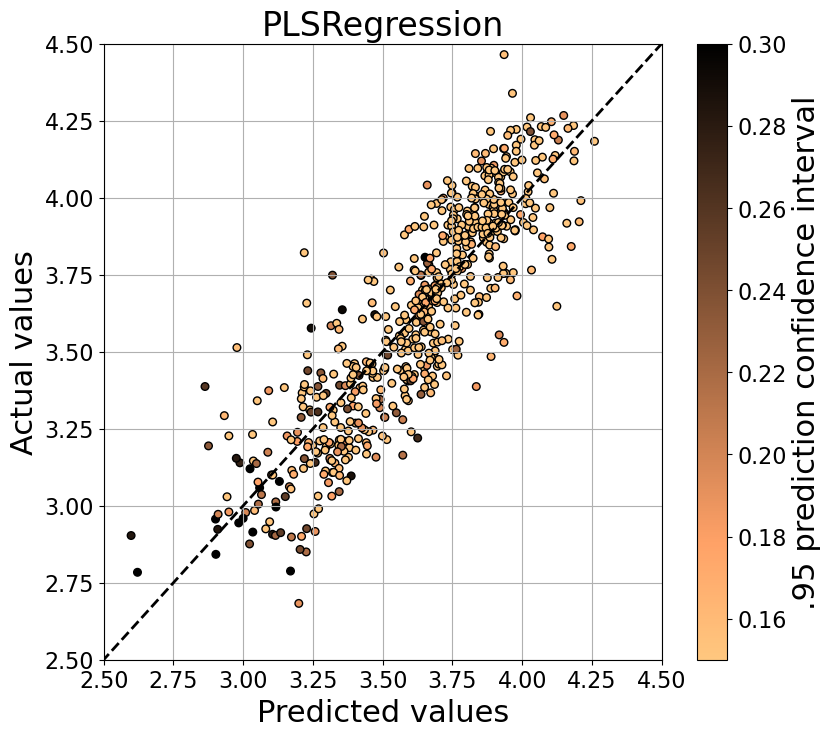

<class 'xgboost.sklearn.XGBRegressor'>


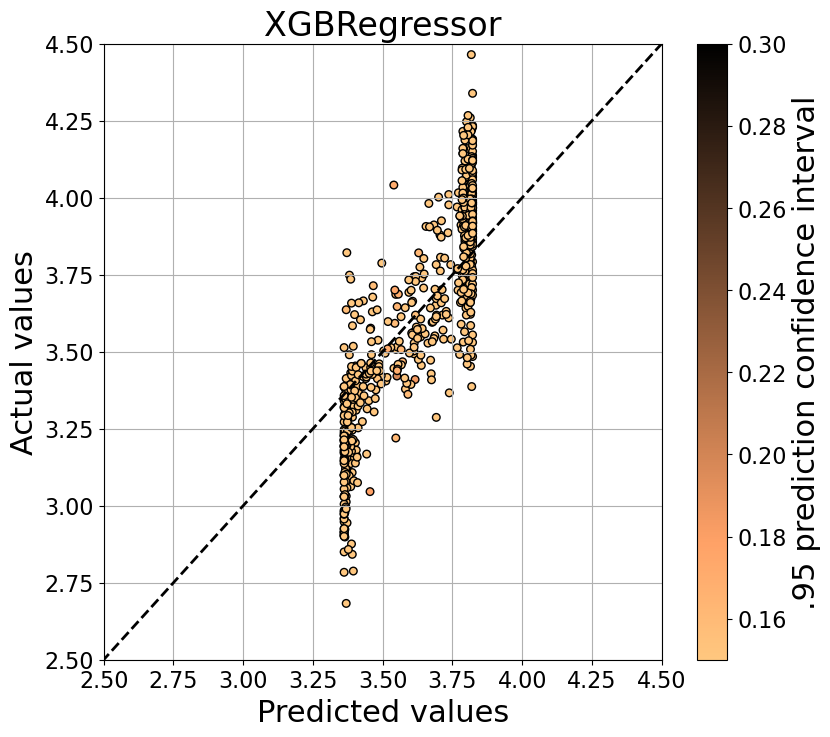

<class 'sklearn.ensemble._forest.RandomForestRegressor'>


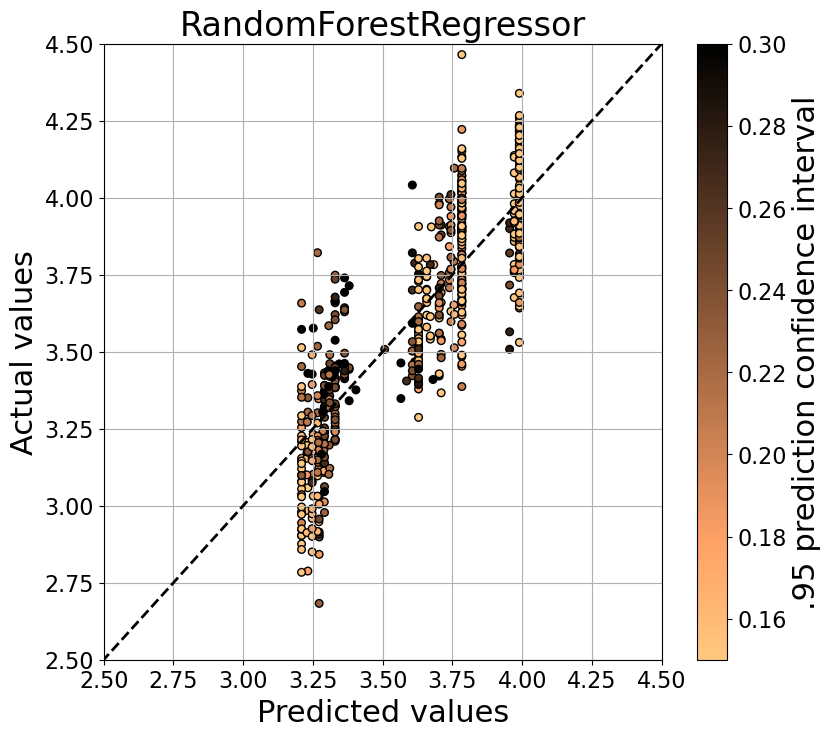

<class 'sklearn.svm._classes.SVR'>


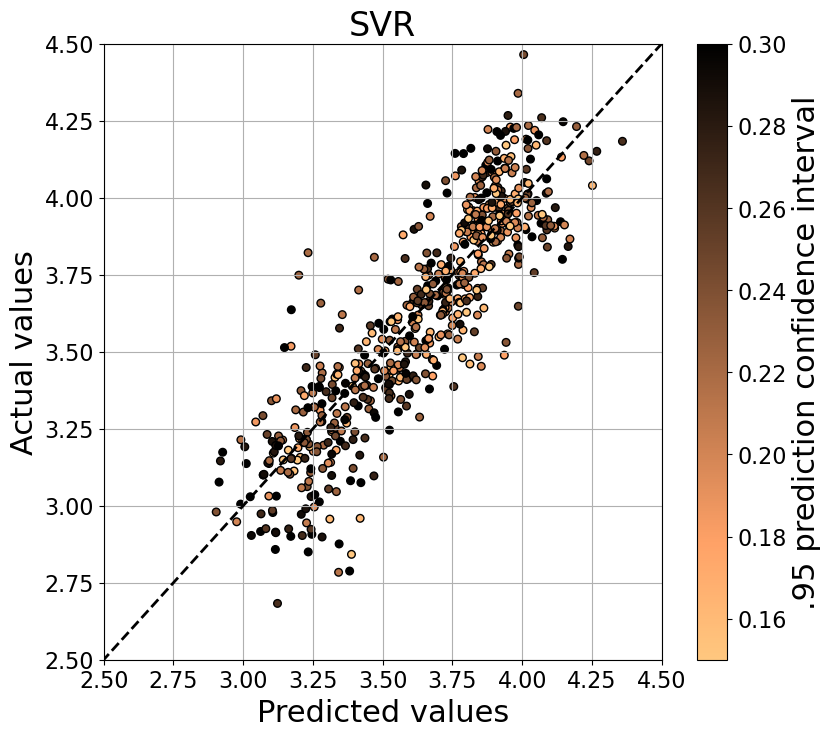

<class 'lightgbm.sklearn.LGBMRegressor'>
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221904
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 946
[LightGBM] [Info] Start training from score 3.618757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222209
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 946
[LightGBM] [Info] Start training from score 3.633995
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221387
[LightGBM] [Info] Number of data points in the train set: 800, number of us

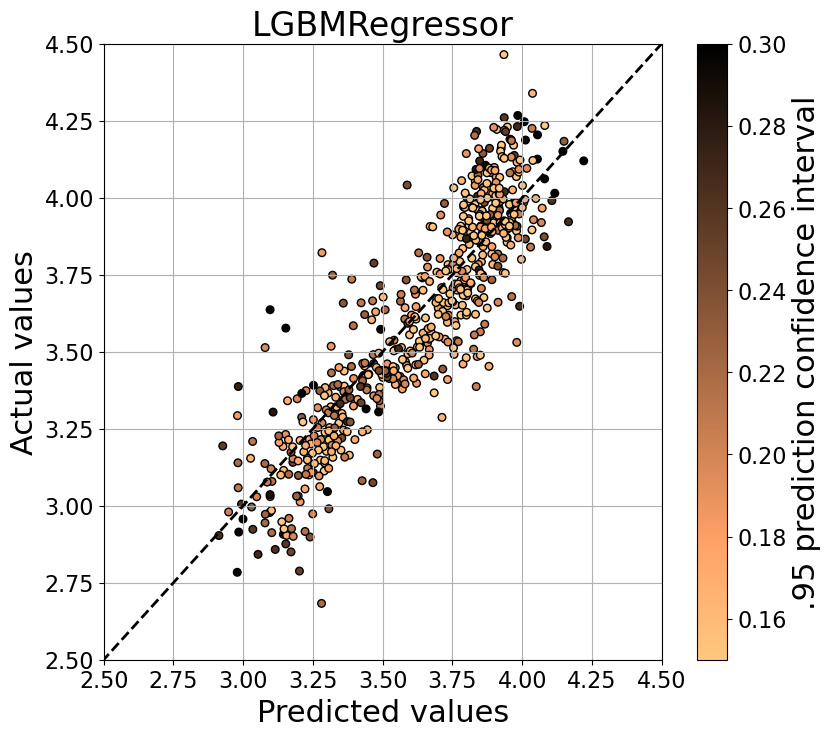

In [23]:
# Function to run bootstrap on a given model, here by randomly selecting 800 samples from the training dataset
def run_bootstrap(model_class, model_name, best_params, X_train, y_train, X_test, y_test, n_iterations=100, n_samples=800): 
    model = model_class(**best_params)
    print(str(model_class))
    y_bootstrap = []

    for i in range(n_iterations):
        X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples=n_samples)
        model.fit(X_bs, y_bs)
        y_hat = model.predict(X_test)
        
        y_hat = y_hat.flatten()
        
        y_bootstrap.append(y_hat)

    y_bootstrap = np.vstack(y_bootstrap)
    uncertainty = pd.DataFrame(y_bootstrap).std(axis=0)
    mean = pd.DataFrame(y_bootstrap).mean(axis=0) ## get mean value of prediction for each sample. 
    y_hat = model.predict(X_test).flatten()

    ## Obtain upper and lower values of confidence intervals at 95% as 1.96 std
    upper_ci = mean + (1.96 * uncertainty)
    lower_ci = mean - (1.96 * uncertainty)
    ci_difference = upper_ci - lower_ci

    diff = pd.DataFrame(ci_difference, columns=['CI']).reset_index()
    y1 = pd.DataFrame(y_hat, columns=['Predicted']).reset_index()
    y2 = pd.DataFrame(y_test).reset_index()
    matrix = pd.concat([diff, y1, y2], sort=False, axis=1)

    ## Draw scatterplot of predicted vs actual values, colored by confidence intervals
    plt.figure(figsize=(9, 8))
    plt.xlabel('Predicted values', fontsize=22)
    plt.ylabel('Actual values', fontsize=22)
    plt.grid(True)
    plt.scatter(matrix['Predicted'], matrix['RLLD'], c=matrix['CI'], cmap='copper_r', vmin=0.15, vmax=0.3, marker='o', s=30, edgecolor='black', linewidth=1)

    clb = plt.colorbar()
    clb.set_label('.95 prediction confidence interval', fontsize=22)
    clb.ax.tick_params(labelsize=16)  
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(2.5, 4.5)
    plt.ylim(2.5, 4.5)
    plt.title(model_name, fontsize=24)
    plt.plot([1, 5], [1, 5], linestyle='--', color='black', linewidth=2, label='y=x')
    
    plt.show()

# Extract parameters correctly from best_trials
best_params_plsr = best_trials['PLSR'].params
best_params_svr = best_trials['SVR'].params
best_params_rfr = best_trials['RFR'].params
best_params_lgbr = best_trials['LGBR'].params
best_params_xgbr = best_trials['XGBR'].params

# Run the bootstrap and plot for each model
run_bootstrap(PLSRegression, 'PLSRegression', best_params_plsr, X_train, y_train, X_test, y_test)
run_bootstrap(xgboost.XGBRegressor, 'XGBRegressor', best_params_xgbr, X_train, y_train, X_test, y_test)
run_bootstrap(RandomForestRegressor, 'RandomForestRegressor', best_params_rfr, X_train, y_train, X_test, y_test)
run_bootstrap(SVR, 'SVR', best_params_svr, X_train, y_train, X_test, y_test)
run_bootstrap(LGBMRegressor, 'LGBMRegressor', best_params_lgbr, X_train, y_train, X_test, y_test)

## Feature importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238565
[LightGBM] [Info] Number of data points in the train set: 1730, number of used features: 946
[LightGBM] [Info] Start training from score 3.620594


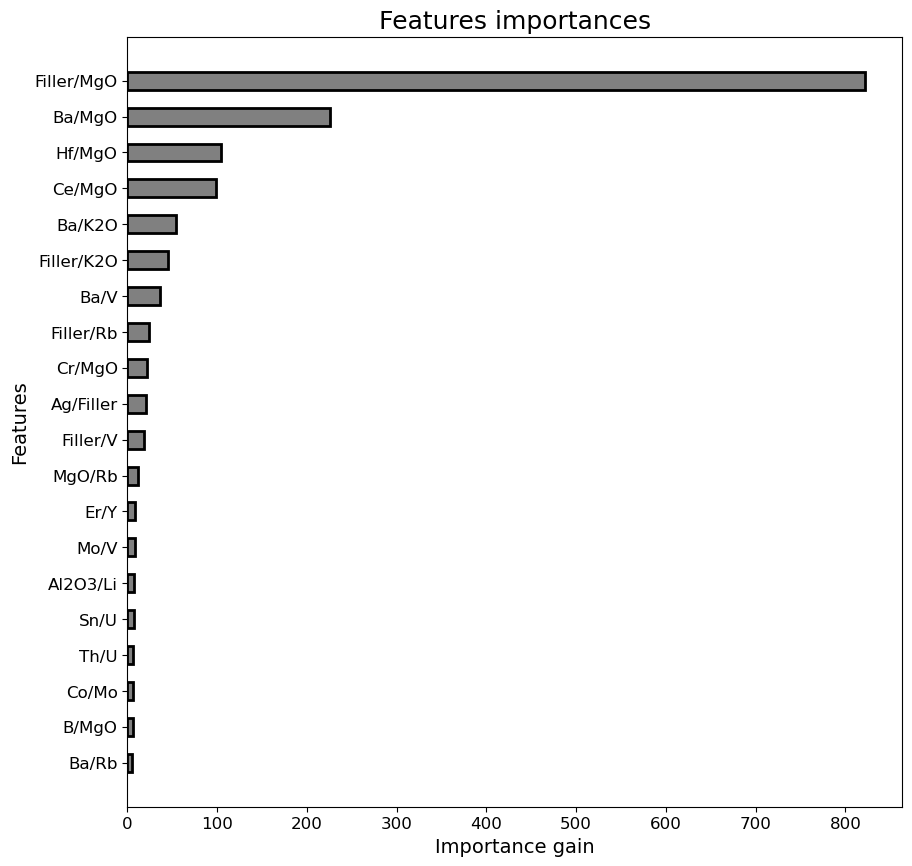

In [25]:
## Feature importance

best_model = LGBMRegressor (**best_trials['LGBR'].params)
best_model.fit (X_train, y_train)

# Get feature importance values
features = pd.concat([ geochem_pwlr_training], axis=1)
features.columns = features.columns.astype(str)

feature_names = features.columns
importance_values = best_model.booster_.feature_importance(importance_type='gain')

# Sort features by importance
sorted_indices = np.argsort(importance_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Plot bar chart for features importances
fig, ax = plt.subplots(figsize=(10, 10))

bar_colors = 'grey'
bar_height = 0.5  # Adjust the height as needed

ax.barh(sorted_feature_names[:20][::-1], sorted_importance_values[:20][::-1], color=bar_colors, height=bar_height, edgecolor='black', linewidth=2)

# Customize the plot
ax.set_title('Features importances', fontsize=18) 
ax.set_xlabel('Importance gain', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)
plt.show()

## Prediction on the external dataset

In [30]:
## Preprocessing on the external dataset
# As the external dataset was separated prior to train-test split, it needs first to be preprocessed before using the model on it. 

## IR spectroscopy
ir_get_cr = data_get.loc[:, '1000':'2400']
ir_get_ss = pd.DataFrame(savgol_filter(ir_get_cr, 25, polyorder = 2, deriv = 0))
ir_get_fod = pd.DataFrame(savgol_filter(ir_get_cr, 25, polyorder = 2, deriv = 1))
ir_get_sod = pd.DataFrame(savgol_filter(ir_get_cr, 25, polyorder = 2, deriv = 2))

## Geochemical data
geochem_get = data_get.loc[:, 'Ag':'Filler']

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_get.columns for element2 in geochem_get.columns if element1 < element2]
geochem_pwlr_get = pd.DataFrame(index=geochem_get.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_get[element1] / geochem_get[element2])
    geochem_pwlr_get[log_ratio_column] = log_ratios

X_get = geochem_pwlr_get
X_get.columns = X_get.columns.astype(str)
X_get = StandardScaler().fit_transform(X_get)

## Define target variable
y_get = np.log10(data_get['RLLD'])

####
pd.DataFrame(X_get)

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,0.805647,-2.647705,0.285082,-0.380768,0.651248,0.534210,0.753010,-2.208087,0.007011,-0.131579,...,0.563993,0.568925,0.669940,0.393258,-0.031555,0.385837,-0.660086,-0.064264,0.091533,0.417262
1,1.931763,-2.126988,1.418271,-0.310418,1.412931,0.319908,0.847551,-1.362395,1.060377,0.885403,...,-0.107184,-0.068954,-0.041217,-0.584631,-0.229696,0.495368,-0.663173,-0.550657,-0.265875,-0.562125
2,1.754124,0.142938,1.669194,-0.086633,2.088423,-0.091665,1.178015,0.939467,1.136389,0.836000,...,-1.036994,-1.616424,-1.201656,-1.892243,-1.699327,-1.121158,-0.691962,-2.135596,-2.122235,-2.084070
3,0.419482,0.321413,0.999444,0.029540,0.843972,0.119481,0.566921,1.146300,1.235794,1.241677,...,-0.240709,-0.443599,-0.504254,-0.529901,0.266093,-0.145342,-0.481983,0.136553,-0.138718,-0.297804
4,1.631244,0.856500,1.713569,0.702135,1.504941,-0.252831,0.541777,1.063003,1.558846,1.378134,...,-1.214987,-1.158472,-1.527053,-1.608280,-0.678804,-1.063520,-0.683268,-0.957254,-1.394223,-1.475133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.494280,-0.815884,-0.319544,-0.765724,-0.460253,-0.159493,-0.474900,-0.389018,-1.459913,-1.370159,...,0.958296,0.443153,0.539921,1.280677,0.520016,1.216925,-0.184263,-0.346964,0.554669,0.945853
294,2.162942,-0.302815,0.858820,-0.047305,1.312848,-0.022641,-0.657878,-0.389018,-0.041005,0.200248,...,1.032822,0.065102,0.300092,0.908330,-1.050146,0.082024,-1.039834,-0.739565,0.206463,0.882804
295,-0.704920,-0.298314,-0.319544,-0.380768,-0.621596,-0.655346,-0.196810,0.097896,-0.597293,-0.480276,...,0.271086,-0.438666,0.115906,0.074548,-0.738471,-0.099508,-0.829210,-0.932412,-0.504908,0.084604
296,-2.229741,-0.519963,-0.878995,-0.765724,-1.509032,-0.323236,-0.474900,-0.062560,0.000962,0.110413,...,1.561890,1.310721,1.569699,1.513117,0.351826,0.366905,-0.206630,1.433346,1.643711,2.198381


In [35]:
## Prediction on the external dataset

best_params = {'n_estimators': 72, 'reg_alpha': 0.14002824939901107, 'reg_lambda': 0.006438311069718575, 'colsample_bytree': 0.4, 'subsample': 0.4, 
               'learning_rate': 0.04757491442812937, 'max_depth': 9, 'num_leaves': 9, 'min_child_samples': 13}
best_model = LGBMRegressor (**best_params)
best_model.fit (X_train, y_train)

y_c = pd.DataFrame(best_model.predict(X_get))

y_c.columns = ['Predicted_values']
print(len(y_c))
## Uncertainty prediction

y_bootstrap_get = []
# bootstrap predictions
accuracy = []
n_iterations = 25
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples = 1000)
    best_model.fit(X_bs,y_bs)
    # make predictions
    y_hat = best_model.predict(X_get)
    print(i)
    y_bootstrap_get.append(y_hat)
    
y_bootstrap_get = pd.DataFrame(np.vstack(y_bootstrap_get))

##
uncertainty = pd.DataFrame(y_bootstrap_get).std(axis = 0)
mean = pd.DataFrame(y_bootstrap_get).mean(axis = 0)
y_hat = best_model.predict(X_get)
print(len(y_hat))
upper_ci = mean + 1.96 * uncertainty
lower_ci = mean - 1.96 * uncertainty
ci_difference = upper_ci - lower_ci


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238565
[LightGBM] [Info] Number of data points in the train set: 1730, number of used features: 946
[LightGBM] [Info] Start training from score 3.620594
298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229142
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 946
[LightGBM] [Info] Start training from score 3.632959
0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229763
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 946
[LightGBM] [Inf

## Formatting and export for synthetic logs

In [36]:
## The obtained predictions and their confidence intervals on the external dataset are then concatenated to the external dataset and exported. 
## Using graphical tools, one can then redraw synthetic logs with actual and predicted values to assess the ability of the model to cover his needs. 

actual_values = np.log10(data_get['RLLD'])
predicted_values = y_c
min_ci = pd.DataFrame(lower_ci, columns = ['Lower_CI'])
max_ci = pd.DataFrame(upper_ci, columns = ['Upper_CI'])
collar = data_get.loc[:, 'HoleName':'SAMPTO']

actual_values = actual_values.reset_index(drop = True)
predicted_values = predicted_values.reset_index(drop = True)
min_ci = min_ci.reset_index(drop = True)
max_ci = max_ci.reset_index(drop = True)
collar = collar.reset_index(drop = True)

prediction_get = pd.concat ([collar, actual_values, predicted_values, min_ci, max_ci], axis = 1, sort = False)

prediction_get

,HoleName,SAMPFROM,SAMPTO,RLLD,Predicted_values,Lower_CI,Upper_CI
0,GRL161A,38.7,60.0,3.747775,3.636053,3.420387,3.710834
1,GRL161A,60.0,80.0,3.649273,3.574536,3.378748,3.673128
2,GRL161A,80.0,100.0,3.175541,3.253983,3.177977,3.399962
3,GRL161A,100.0,120.0,3.170746,3.306248,3.248406,3.383559
4,GRL161A,120.0,140.0,3.202148,3.347497,3.264067,3.466807
...,...,...,...,...,...,...,...
293,GRL221,140.0,150.0,3.146670,3.686943,3.579011,3.773372
294,GRL221,150.0,160.0,3.239655,3.591416,3.354785,3.688731
295,GRL221,160.0,170.0,3.055152,3.312718,3.257895,3.437643
296,GRL221,170.0,180.0,3.167326,3.650630,3.574934,3.764802
